In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Подготовка данных

## Загрузка таблицы
Таблица лежит в папка data в формате .data (при открытии можете убедиться, что это просто csv таблица без заголовка, поэтому в ручную указываем название столбцов)
Orignal data: https://archive.ics.uci.edu/dataset/1/abalone \
Целевой столбец - Rings

In [2]:
cols = ["Sex", "Length", "Diameter",
        "Height", "Whole_weight",
        "Shucked_weight", "Viscera_weight",
        "Shell_weight", "Rings"]
dataframe = pd.read_table("data/abalone.data", sep=",", names=cols)
dataframe.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Столбцы
Извлекаем название стоблцов и группируем их по типам для дальнейшего анализа

In [3]:
int_col = dataframe.select_dtypes(int).columns.to_list()[0]
float_cols = dataframe.select_dtypes(float).columns.to_list()
cat_col = dataframe.select_dtypes(object).columns.to_list()[0]
int_col, float_cols, cat_col

('Rings',
 ['Length',
  'Diameter',
  'Height',
  'Whole_weight',
  'Shucked_weight',
  'Viscera_weight',
  'Shell_weight'],
 'Sex')

#### Категориальные данные
У нас получился один категориальный столбец - Sex. Посмотрим его содержимое с помощью pie диаграммы.

([<matplotlib.patches.Wedge at 0x11ec40510>,
 [Text(0.45010440780275796, 1.0036961801643607, 'M'),
  Text(-1.0848393519507589, -0.18199884741134378, 'F'),
  Text(0.6099659291018239, -0.9153914820091725, 'I')])

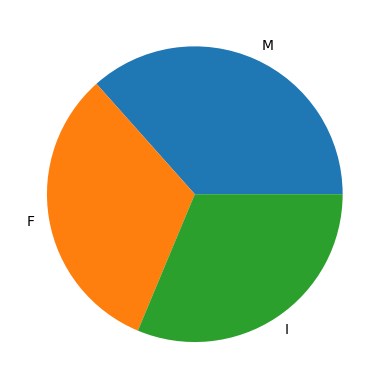

In [4]:
plt.pie(x=dataframe[cat_col].value_counts().to_numpy(), labels=dataframe[cat_col].unique())

Категорий примерно одинаковое количество, что хорошо для обучения моделей

#### Целочисленные данные
Целочисленных тоже один столбец, это целевой столбец - Rings. Изобразим значения этого столбца на столбчатой диаграмме.

(array([  17.,  431., 1648., 1388.,  329.,  228.,  100.,   29.,    4.,
           3.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

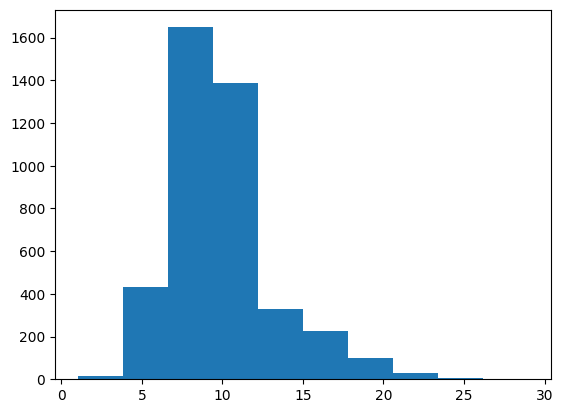

In [5]:
plt.hist(x=dataframe[int_col].to_numpy())

Как видим - у Rings есть некоторые шумы, такие как значения 25-30 и значения близкие к 0, но в целом распределение неплохое

#### Вещественные значения
Для вещественных значений нарисуем график "ящик с усиками". https://wiki.loginom.ru/articles/box-plot.html

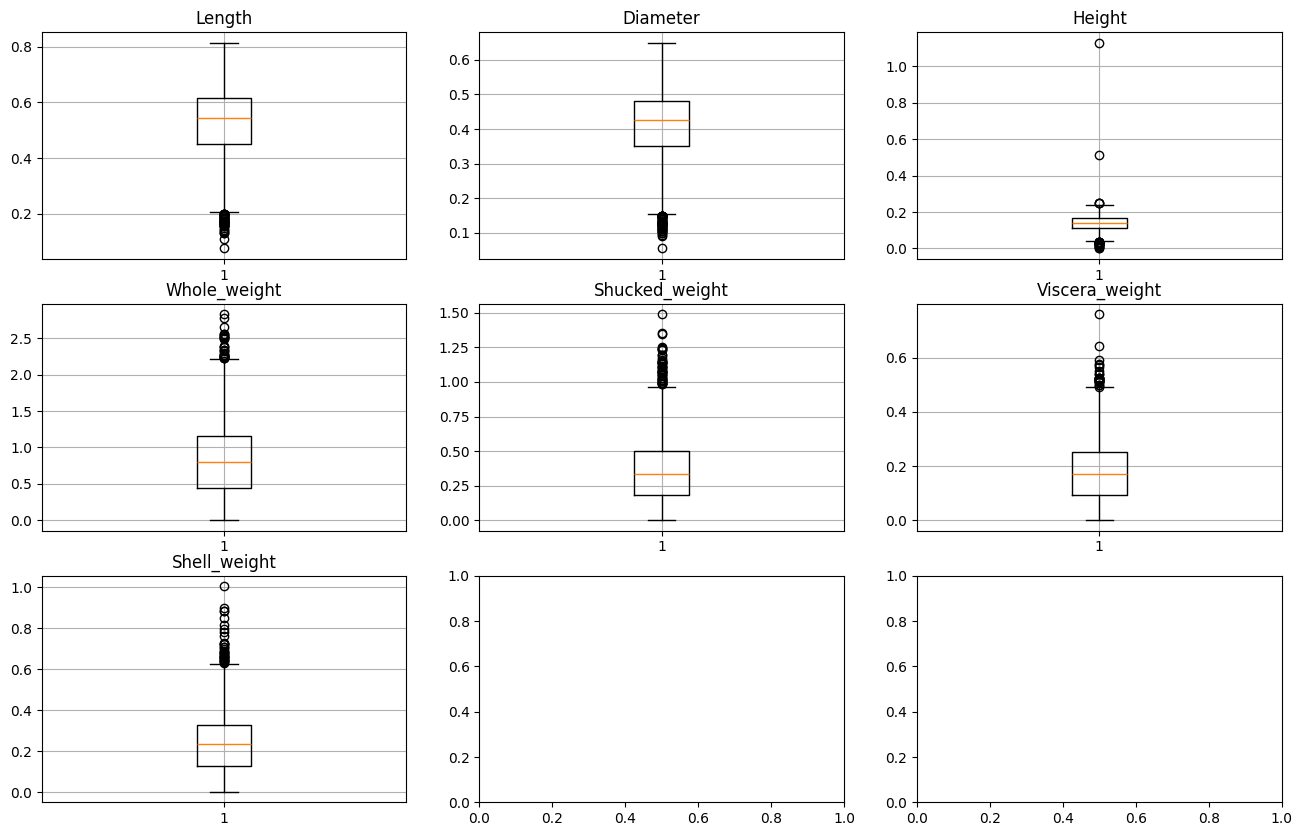

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,10))

count = 0
for i in range(3):
    for j in range(3):
        if count == len(float_cols):
            break
        
        col = float_cols[count]
        axes[i, j].boxplot(dataframe[col].to_numpy())
        axes[i, j].set_title(col)
        axes[i, j].grid()
        count += 1

На графиках видно, что у данных немало выбросов, но с этим мало что можно сделать, только если удалить данные с выбросами или заменить их на медианные значения, но это может повлиять на качество модели, поэтому лучше выбрать модели устойчивые к выбросам данных.

#### Кодируем категориальные признаки
Категориальный признак всего один, поэтому достаточно LabelEncoder, который вместо категорий подставляет целые числа.

In [7]:
from sklearn.preprocessing import LabelEncoder


cat_encoder = LabelEncoder()
cat_encoder.fit(dataframe[cat_col])
dataframe[cat_col] = cat_encoder.transform(dataframe[cat_col])
dataframe.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Корреляция данных
Изучем корреляцию данных для линейных зависимостей

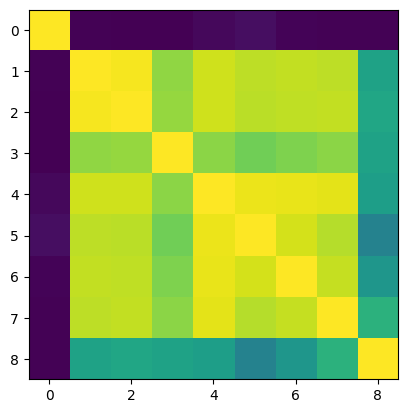

In [8]:
plt.imshow(dataframe.corr())

Как видим последний столбец не очень хорошо коррелирует со всеми остальными, значит линейные модели буду показывать небольшую точность

## Нормализуем данные
Нормализуем данные и извлечем X и y в numpy массивы

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dataframe.to_numpy())
data = scaler.transform(dataframe)
X, y = data[:, :-1], data[:, -1]
X.shape, y.shape

/Users/danila/Documents/Python Projects/Kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


((4177, 8), (4177,))

# Выбор моделей

## Кросс валидация
Выберем модели на основе метрики R^2 с помощью cross_val_score \
Значения метрики лежат от 0 до 1 (самая точная модель), но могут получатся и отрицательные значения 

In [75]:
# создает из введенное с уже инициализированными параметрами
from functools import partial
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score


scorer = make_scorer(r2_score)
validate = partial(cross_val_score, X=X, y=y, cv=5, n_jobs=-1, scoring=scorer)

### Импортируем алгоритмы

In [76]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

### Линейная регрессия

In [77]:
validate(LinearRegression()).mean()

0.39803615577874024

### Линейная регрессия с L2 регуляризацией

In [78]:
validate(Ridge()).mean()

0.39883812008570196

### Линейная регрессия с L1 регуляризацией

In [79]:
validate(Lasso()).mean()

-0.2090330540722419

### Линейная регрессия с L1 и L2 регуляризациями

In [80]:
validate(ElasticNet()).mean()

-0.076376059316807

### Случайный лес

In [81]:
validate(RandomForestRegressor()).mean()

0.4403316342374315

### Градиентный бустинг

In [82]:
validate(GradientBoostingRegressor()).mean()

0.4632399016247442

### XGBoosting

In [83]:
validate(XGBRegressor()).mean()

0.39163807497663533

### К-ближайших соседей

In [84]:
validate(KNeighborsRegressor()).mean()

0.4023810671413547

### Решающее дерево

In [85]:
validate(DecisionTreeRegressor()).mean()

-0.19038828536303773

Самыми точными моделями получились - К-ближайших соседей, XGBoosting, Градиентный бустинг и Случайный лес \
Заметим, что 3 из 4 алгоритмов основаны на решающих деревьях, значит РД - это база!

# Оптимизация гиперпараметров
Найдем оптимальные гиперпараметры выбранных моделей \
Оптимизацию проведем с помощьюб библиотеки [__optuna__](https://optuna.org/) \
Можно также воспользоваться средствами __scikit-learn__ из модуля __model_selection__, но он предоставляет только оптимизацию гиперпараметров по сетке (GridSearchCV) и случайный поиск по сетке (RandomSearchCV), но данные алгоритмы не являются оптимальными

In [94]:
def xgb_objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, log=True)
    }
    regression_obj = XGBRegressor(**params)
    
    score = validate(regression_obj).mean()
    return score


def random_forest_objective(trial):
    rf_max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 500, step=20)
    regression_obj = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
    
    score = validate(regression_obj).mean()
    return score


def boosting_objective(trial):
    bst_max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    bst_lr = trial.suggest_float('learning_rate', 1e-4, 5e-1, log=True)
    bst_min_samples_split = trial.suggest_int('min_samples_split', 2, 5, log=True)
    bst_n_estimators = trial.suggest_int('n_estimators', 10, 500, log=True)
    regression_obj = GradientBoostingRegressor(n_estimators=bst_n_estimators,
                                               max_depth=bst_max_depth,
                                               min_samples_split=bst_min_samples_split,
                                               learning_rate=bst_lr)
    
    score = validate(regression_obj).mean()
    return score


def knn_objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 2, 21, step=1, log=True)
    knn_metric = trial.suggest_categorical('metric', ['manhattan', 'euclidean', 'minkowski'])
    regression_obj = KNeighborsRegressor(n_neighbors=knn_n_neighbors,
                                         metric=knn_metric)
    
    score = validate(regression_obj).mean()
    return score


objectives = [
    ('xgb', xgb_objective),
    ('rf', random_forest_objective),
    ('boosting', boosting_objective),
    ('knn', knn_objective)
]

## Создаем Study объекты для каждой модели
Оптимизация занимает продолжительное время, у меня получилось около 15 минут

In [116]:
from optuna import create_study


studies = [None] * len(objectives)
for i, (name, objective) in enumerate(objectives):
    studies[i] = create_study(study_name=name, direction='maximize')
    studies[i].optimize(objective, n_trials=100)

[I 2024-04-02 22:45:57,523] A new study created in memory with name: xgb
[I 2024-04-02 22:45:58,461] Trial 0 finished with value: -0.15690441194954338 and parameters: {'booster': 'gbtree', 'lambda': 4.124098300656127e-05, 'alpha': 0.028268557563523783, 'learning_rate': 0.0007798747874934989, 'n_estimators': 53}. Best is trial 0 with value: -0.15690441194954338.
[I 2024-04-02 22:45:58,846] Trial 1 finished with value: -0.19807662809551235 and parameters: {'booster': 'gblinear', 'lambda': 8.0349439487715e-05, 'alpha': 0.5055881490872028, 'learning_rate': 0.0005314339005948595, 'n_estimators': 39}. Best is trial 0 with value: -0.15690441194954338.
[I 2024-04-02 22:45:59,962] Trial 2 finished with value: -0.18341392508343174 and parameters: {'booster': 'dart', 'lambda': 3.4653652147930366e-05, 'alpha': 1.1870127916555968e-08, 'learning_rate': 0.0002730481940397657, 'n_estimators': 73}. Best is trial 0 with value: -0.15690441194954338.
[I 2024-04-02 22:46:02,299] Trial 3 finished with value

## Извлекаем лучшие параметры

In [117]:
params = {objectives[i][0]: study.best_params for i, study in enumerate(studies)}

# Создание ансамбля

В качестве ансамбля был выбран Stacking, на первом уровне наши оптимизированные алгоритмы, в качестве мета-алгоритма выбрана линейная регрессия с L2 регуляризацией с встроенной кросс-валидацией (_RidgeCV_)

In [118]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold


regressor_ensemble = StackingRegressor(estimators=[
    ('rf', RandomForestRegressor(**params['rf'])),
    ('boosting', GradientBoostingRegressor(**params['boosting'])),
    ('knn', KNeighborsRegressor(**params['knn'])),
    ('xgb', XGBRegressor(**params['xgb']))
],
                                       final_estimator=RidgeCV(),
                                       cv=KFold(n_splits=5),
                                       n_jobs=-1)

## Обучение ансамбля
При инициализации ансамбля была выбрана KFold кросс валидация с 5 сплитами для обучена мета-алгоритма \
Выберем ту же самую кросс валидацию для обучения всего ансамбля

1 split finished
2 split finished
3 split finished
4 split finished
5 split finished


0.47584157981407926

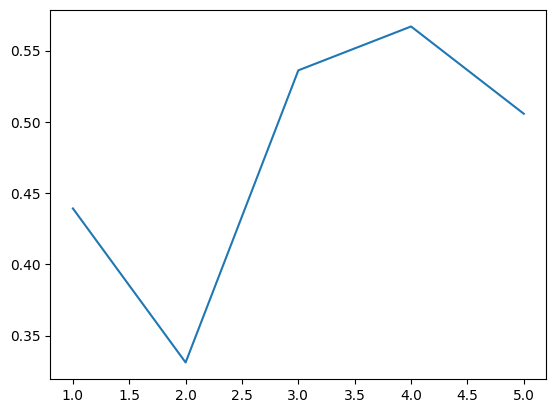

In [119]:
import numpy as np


splitter = KFold(n_splits=5)
scores = np.empty(0)
for i, (train_index, test_index) in enumerate(splitter.split(X, y)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    
    regressor_ensemble.fit(X_train, y_train)
    
    logits = regressor_ensemble.predict(X_test)
    scores = np.hstack([scores, r2_score(y_test, logits)])
    
    print(f'{i + 1} split finished')

plt.plot(np.arange(1, scores.size + 1), scores)
scores.mean()

Отличный результат у ансамбля, среднее значение метрики увеличилось и равно - 0.4759!

# Интерпретация результатов
У класса _StandartScaler_ есть атрибуты mean_ (среднее) и scale_ (стандартное отклонение), подставих их в формулу, можно получить обратно не масштабированные значения: \
$x = x_{norm}scale\_+mean\_$

In [120]:
input_ = X[0].reshape(1, -1)
logit = regressor_ensemble.predict(input_)

print(logit * scaler.scale_[-1] + scaler.mean_[-1])

[10.53489155]


# Возможные улучшения
- Разобраться с выбросами
- Поэкспериментировать с мета-алгоритмом ансамбля